In [1]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Reading and processing dataset 

In [3]:
dataset_root = 'NSL-KDD_datasets/nsl-kdd'

In [4]:
train_file = os.path.join(dataset_root, 'KDDTrain+.txt')
test_file = os.path.join(dataset_root, 'KDDTest+.txt')

In [5]:
# Original KDD dataset feature names obtained from 
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']

In [6]:
# Differentiating between nominal, binary, and numeric features

# root_shell is marked as a continuous feature in the kddcup.names 
# file, but it is supposed to be a binary feature according to the 
# dataset documentation

col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

In [7]:
# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types

category = defaultdict(list)
category['benign'].append('normal')

with open('training_attack_types.txt', 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v,k) for k in category for v in category[k])

## Generating and analyzing train and test sets

In [8]:
# header_names는 데이터와 같은 순서로 정렬된 속성 이름의 리스트다.
# 레이블(CSV 끝에서 두개) 이름은 'attack_type'이고, CSV의 마지막 값은 'success_pred'다.

# 훈련 데이터를 불러온다.
train_df = pd.read_csv(train_file, names=header_names)
train_df['attack_category'] = train_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
train_df.drop(['success_pred'], axis=1, inplace=True)
    
# 테스트 데이터를 불러온다.
test_df = pd.read_csv(test_file, names=header_names)
test_df['attack_category'] = test_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
test_df.drop(['success_pred'], axis=1, inplace=True)

In [9]:
train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()

In [10]:
test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

<Axes: ylabel='attack_type'>

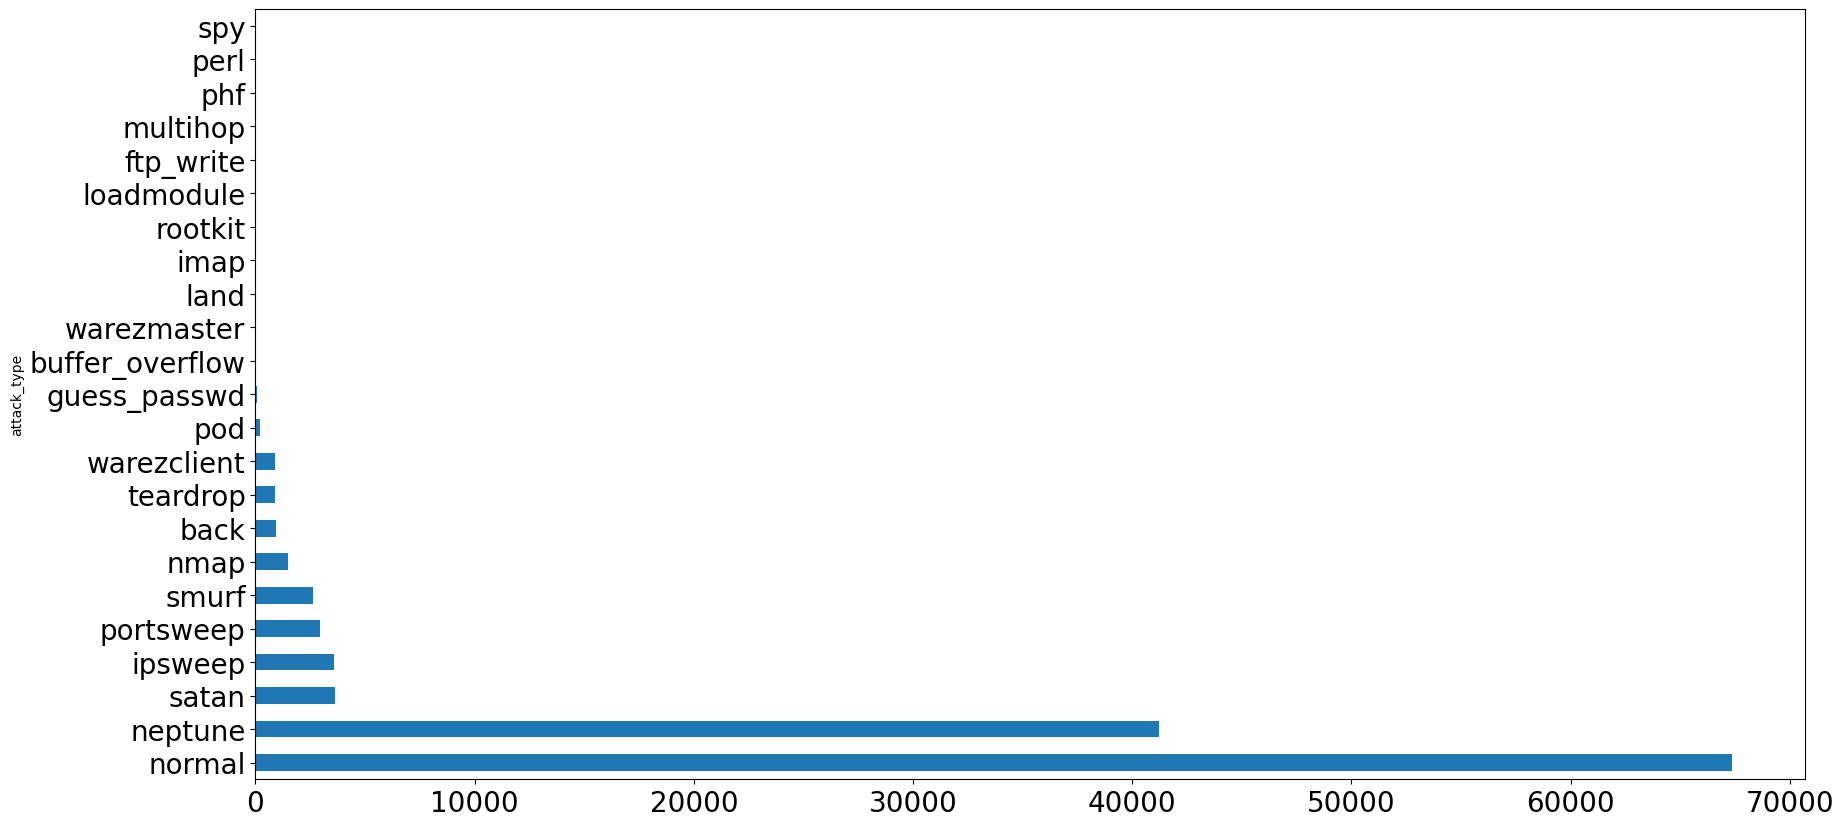

In [11]:
train_attack_types.plot(kind='barh', figsize=(20,10), fontsize=20)

<Axes: ylabel='attack_category'>

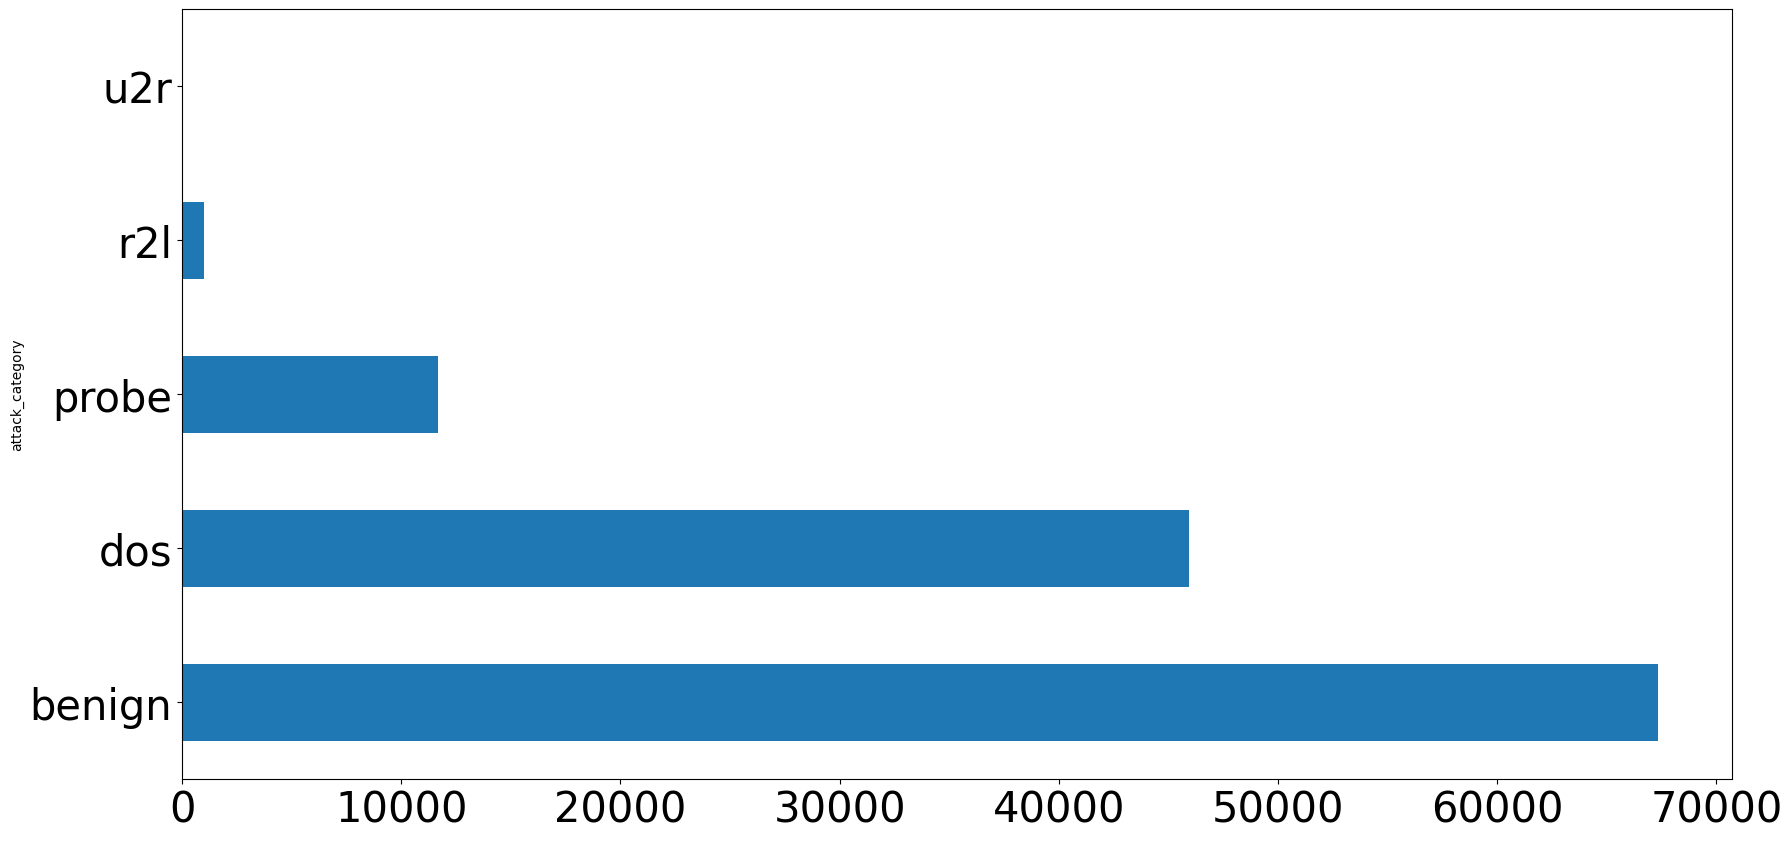

In [12]:
train_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

<Axes: ylabel='attack_type'>

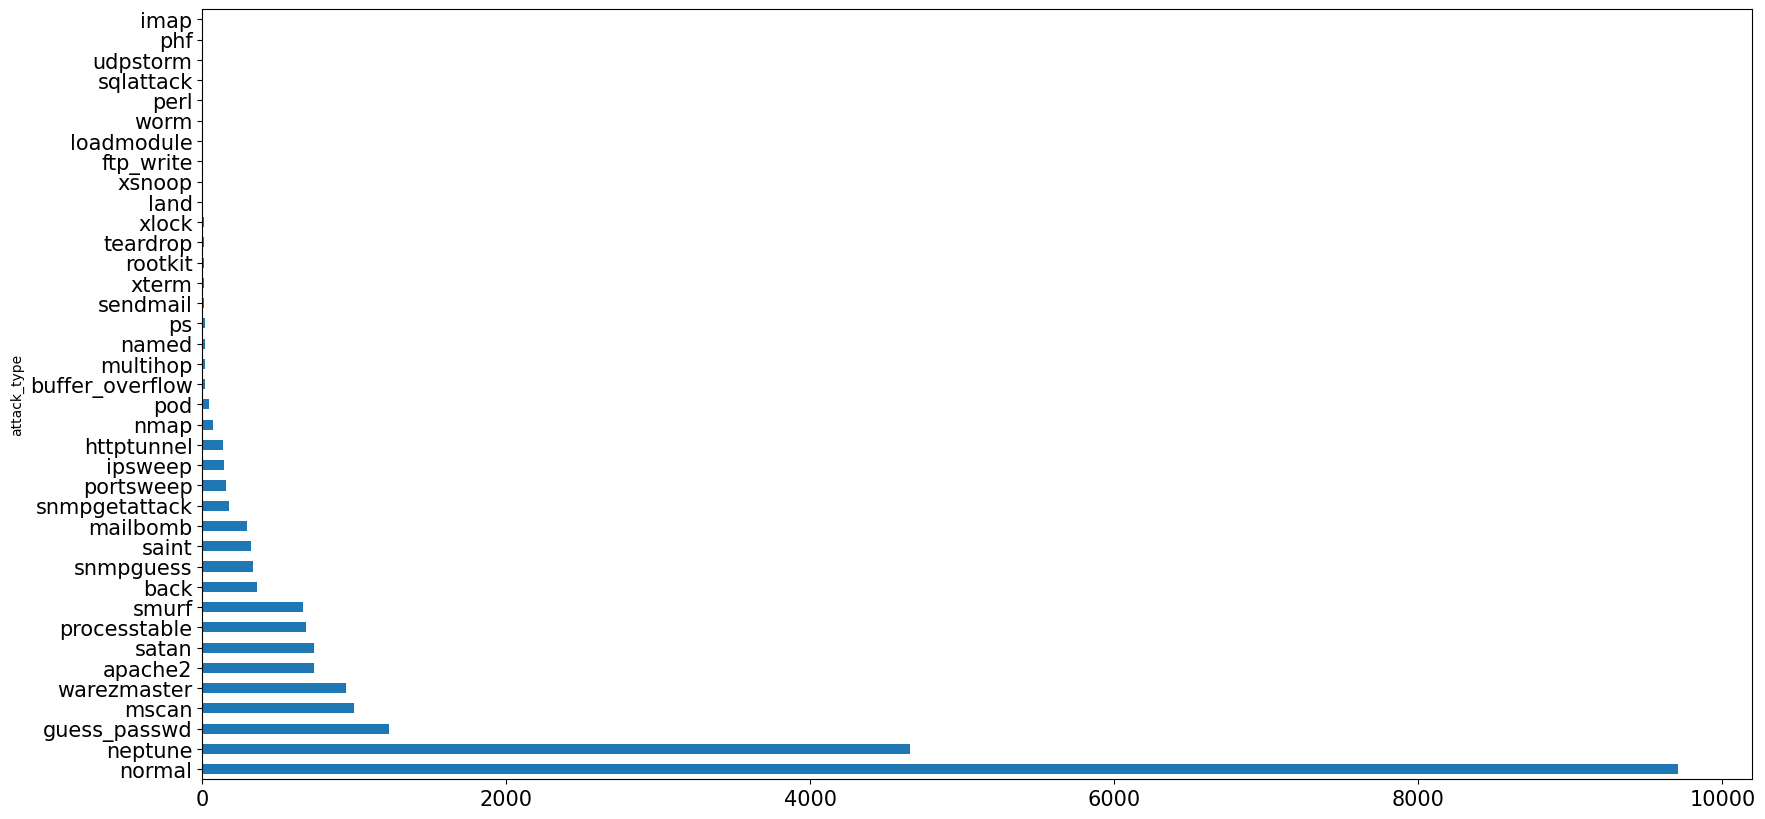

In [13]:
test_attack_types.plot(kind='barh', figsize=(20,10), fontsize=15)

<Axes: ylabel='attack_category'>

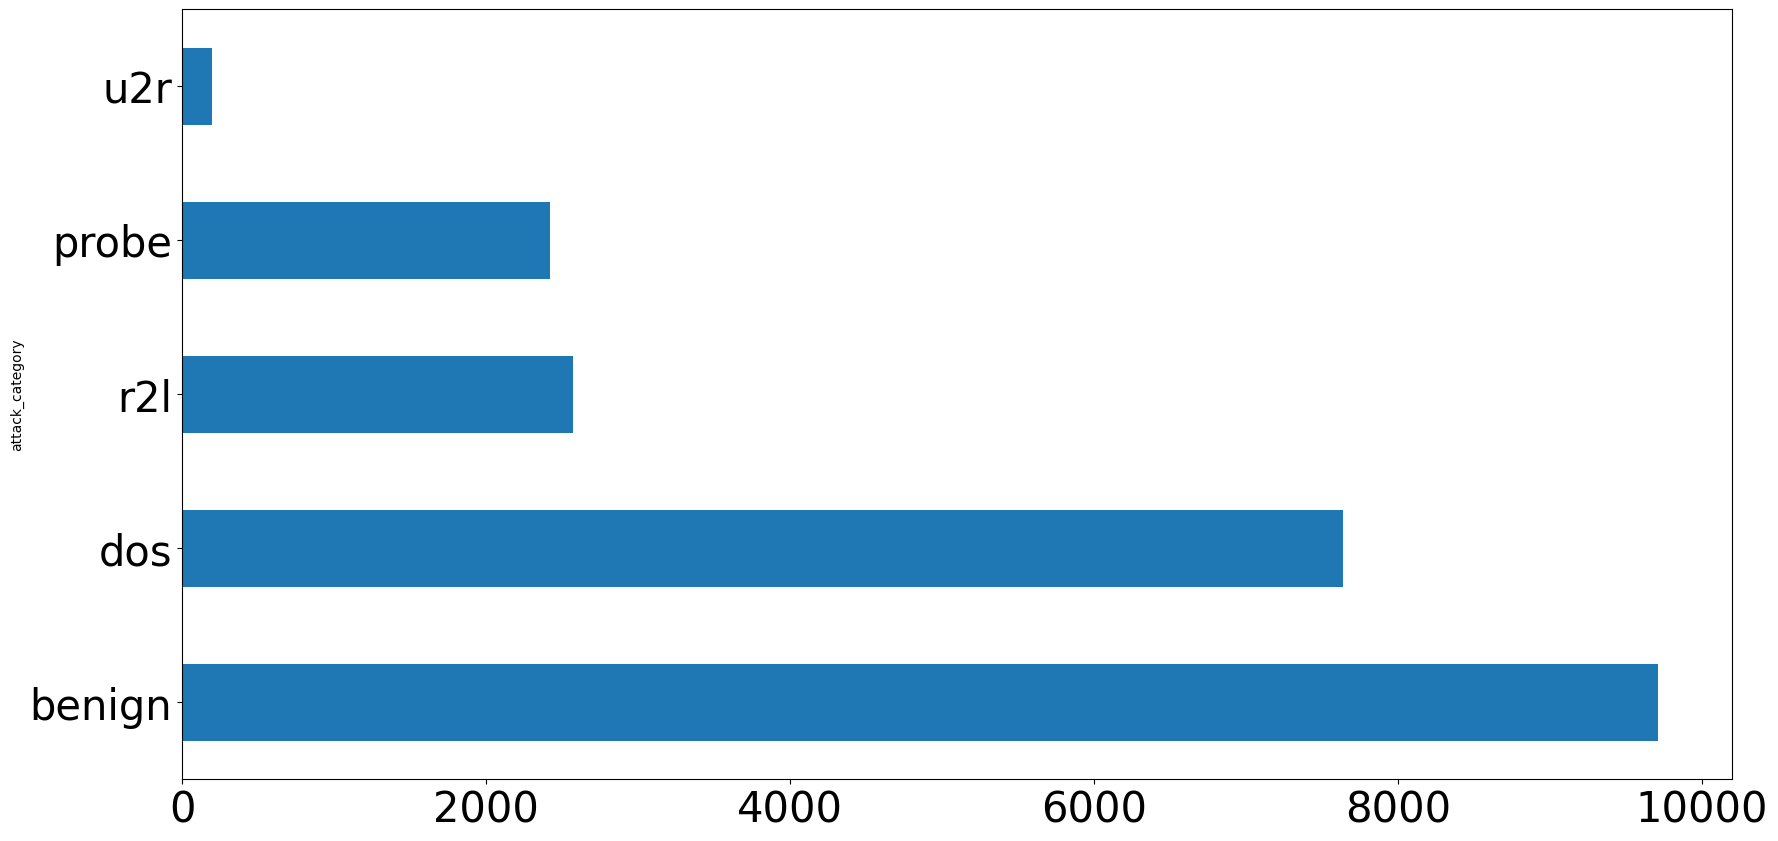

In [14]:
test_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

In [15]:
# Let's take a look at the binary features
# By definition, all of these features should have a min of 0.0 and a max of 1.0

train_df[binary_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
land,125973.0,0.000198,0.014086,0.0,0.0,0.0,0.0,1.0
logged_in,125973.0,0.395736,0.489010,0.0,0.0,0.0,1.0,1.0
root_shell,125973.0,0.001342,0.036603,0.0,0.0,0.0,0.0,1.0
su_attempted,125973.0,0.001103,0.045154,0.0,0.0,0.0,0.0,2.0
is_host_login,125973.0,0.000008,0.002817,0.0,0.0,0.0,0.0,1.0
is_guest_login,125973.0,0.009423,0.096612,0.0,0.0,0.0,0.0,1.0


In [16]:
# Wait a minute... the su_attempted column has a max value of 2.0?

train_df.groupby(['su_attempted']).size()

su_attempted
0    125893
1        21
2        59
dtype: int64

In [17]:
# Let's fix this discrepancy and assume that su_attempted=2 -> su_attempted=0

train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)
train_df.groupby(['su_attempted']).size()

su_attempted
0    125952
1        21
dtype: int64

In [18]:
# Next, we notice that the num_outbound_cmds column only takes on one value!

train_df.groupby(['num_outbound_cmds']).size()

num_outbound_cmds
0    125973
dtype: int64

In [19]:
# Now, that's not a very useful feature - let's drop it from the dataset

train_df.drop('num_outbound_cmds', axis = 1, inplace=True)
test_df.drop('num_outbound_cmds', axis = 1, inplace=True)
numeric_cols.remove('num_outbound_cmds')

## 데이터 준비

In [20]:
train_Y = train_df['attack_category']
train_x_raw = train_df.drop(['attack_category','attack_type'], axis=1)

test_Y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category','attack_type'], axis=1)

In [21]:
# 데이터 프레임 결합
combined_df_raw = pd.concat([train_x_raw, test_x_raw])

# 더미 변수 생성
combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)

# 훈련 데이터셋과 테스트 데이터셋으로 분리
train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]

# 더미 변수 추첮
dummy_variables = list(set(train_x)-set(combined_df_raw))

In [22]:
train_x.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
# Example statistics for the 'duration' feature before scaling
train_x['duration'].describe()

count    125973.00000
mean        287.14465
std        2604.51531
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max       42908.00000
Name: duration, dtype: float64

In [24]:
# 표준 스케일링 적용
from sklearn.preprocessing import StandardScaler

# 시그널을 스케일러로 변환하고 이 결과가 한 속성이 된다.
durations = train_x['duration'].values.reshape(-1, 1)

standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()

count    1.259730e+05
mean     2.425388e-17
std      1.000004e+00
min     -1.102492e-01
25%     -1.102492e-01
50%     -1.102492e-01
75%     -1.102492e-01
max      1.636428e+01
dtype: float64

In [25]:
# Experimenting with MinMaxScaler on the single 'duration' feature
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler().fit(durations)
min_max_scaled_durations = min_max_scaler.transform(durations)
pd.Series(min_max_scaled_durations.flatten()).describe()

count    125973.000000
mean          0.006692
std           0.060700
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
dtype: float64

In [26]:
# Experimenting with RobustScaler on the single 'duration' feature
from sklearn.preprocessing import RobustScaler

min_max_scaler = RobustScaler().fit(durations)
robust_scaled_durations = min_max_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

count    125973.00000
mean        287.14465
std        2604.51531
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max       42908.00000
dtype: float64

In [27]:
# 훈련 데이터를 StandardScaler에 적합
standard_scaler = StandardScaler().fit(train_x[numeric_cols])

# 훈련 데이터 표준화
train_x[numeric_cols] = \
    standard_scaler.transform(train_x[numeric_cols])

# 훈련 데이터에 적합된 스켕일러에 테스트 데이터 표준화
test_x[numeric_cols] = \
    standard_scaler.transform(test_x[numeric_cols])

In [28]:
train_x.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,1.259730e+05,1.259730e+05,1.259730e+05,125973.000000,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,125973.000000,1.259730e+05,...,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05
mean,2.425388e-17,5.640437e-19,4.512349e-19,0.000198,-1.128087e-18,-2.481792e-18,-1.895187e-17,4.512349e-18,0.395736,-7.896611e-19,...,1.579322e-17,-5.730684e-17,1.053634e-16,-2.295658e-17,3.181206e-17,3.158645e-17,1.737255e-17,-2.594601e-17,4.873337e-17,7.648432e-17
std,1.000004e+00,1.000004e+00,1.000004e+00,0.014086,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,0.489010,1.000004e+00,...,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-1.102492e-01,-7.762241e-03,-4.918644e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,0.000000,-1.166364e-02,...,-1.836071e+00,-1.044721e+00,-1.161030e+00,-4.390782e-01,-4.801968e-01,-2.891034e-01,-6.395319e-01,-6.248708e-01,-3.876346e-01,-3.763870e-01
25%,-1.102492e-01,-7.762241e-03,-4.918644e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,0.000000,-1.166364e-02,...,-1.009507e+00,-9.543885e-01,-1.049659e+00,-4.390782e-01,-4.801968e-01,-2.891034e-01,-6.395319e-01,-6.248708e-01,-3.876346e-01,-3.763870e-01
50%,-1.102492e-01,-7.754745e-03,-4.918644e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,0.000000,-1.166364e-02,...,7.343426e-01,-4.756270e-01,-2.504011e-02,-3.332138e-01,-4.801968e-01,-2.891034e-01,-6.395319e-01,-6.248708e-01,-3.876346e-01,-3.763870e-01
75%,-1.102492e-01,-7.715224e-03,-4.790326e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,1.000000,-1.166364e-02,...,7.343426e-01,1.258754e+00,1.066401e+00,-6.855302e-02,-2.860195e-01,-1.114257e-01,1.608759e+00,1.618955e+00,-3.876346e-01,-3.763870e-01
max,1.636428e+01,2.350675e+02,3.257486e+02,1.000000,1.174348e+01,2.088191e+02,3.571955e+01,1.104972e+02,1.000000,3.123689e+02,...,7.343426e-01,1.258754e+00,1.066401e+00,4.854138e+00,2.756092e+00,8.594782e+00,1.608759e+00,1.618955e+00,2.874410e+00,2.753914e+00


In [29]:
train_Y_bin = train_Y.apply(lambda x: 0 if x is 'benign' else 1)
test_Y_bin = test_Y.apply(lambda x: 0 if x is 'benign' else 1)

In [30]:
# 5-class classification version
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss

classifier = DecisionTreeClassifier(random_state=17)
classifier.fit(train_x, train_Y)

pred_y = classifier.predict(test_x)

results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)

print(results)
print(error)

[[9365   56  289    1    0]
 [1541 5998   97    0    0]
 [ 677  220 1526    0    0]
 [2278    1   14  277    4]
 [ 175    0    5    5   15]]
0.2378903477643719


In [34]:
# 혼동행렬 계산
cm = confusion_matrix(test_Y, pred_y)

classes = ['benign', 'dos', 'probe', 'r2l', 'u2r']

# DataFrame으로 보기 좋게 변환
cm_df = pd.DataFrame(
    cm,
    index=[f"True_{c}" for c in classes],
    columns=[f"Pred_{c}" for c in classes]
)

print(cm_df)

             Pred_benign  Pred_dos  Pred_probe  Pred_r2l  Pred_u2r
True_benign         9365        56         289         1         0
True_dos            1541      5998          97         0         0
True_probe           677       220        1526         0         0
True_r2l            2278         1          14       277         4
True_u2r             175         0           5         5        15


In [ ]:
print(cm_df)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
classifier.fit(train_x, train_Y)

pred_y = classifier.predict(test_x)

results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)

print(results)
print(error)

[[9457   57  193    2    2]
 [1675 5894   67    0    0]
 [ 670  156 1597    0    0]
 [2369    2   37  126   40]
 [ 176    0    4    7   13]]
0.24205997161107173


In [ ]:
from sklearn.svm import LinearSVC

classifier = LinearSVC()
classifier.fit(train_x, train_Y)

pred_y = classifier.predict(test_x)

results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)

print(results)
print(error)

[[9009  208  491    1    2]
 [1906 5720   10    0    0]
 [ 721  120 1490   92    0]
 [2481    1    1   91    0]
 [ 181    2    0    5   12]]
0.2759936124911284


## Dealing with class imbalance

In [ ]:
test_Y.value_counts().apply(lambda x: x/float(len(test_Y)))

attack_category
benign    0.430758
dos       0.338715
r2l       0.114177
probe     0.107479
u2r       0.008872
Name: count, dtype: float64

In [ ]:
train_Y.value_counts().apply(lambda x: x/float(len(train_Y)))

attack_category
benign    0.534583
dos       0.364578
probe     0.092528
r2l       0.007899
u2r       0.000413
Name: count, dtype: float64

In [ ]:
print(pd.Series(train_Y).value_counts())

attack_category
benign    67343
dos       45927
probe     11656
r2l         995
u2r          52
Name: count, dtype: int64


In [ ]:
import sys
!{sys.executable} -m pip install -U imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [imbalanced-learn][imbalanced-learn]


In [ ]:
from imblearn.over_sampling import SMOTE

# SMOTE 오버샘플링을 훈련 데이터에 적용
sm = SMOTE(sampling_strategy='auto', random_state=0)
train_x_sm, train_Y_sm = sm.fit_resample(train_x, train_Y)

print(pd.Series(train_Y_sm).value_counts())

attack_category
benign    67343
dos       67343
r2l       67343
probe     67343
u2r       67343
Name: count, dtype: int64


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

mean_class_size = int(pd.Series(train_Y).value_counts().sum() / 5)

sampling_strategy = {
    'benign': mean_class_size,
    'dos': mean_class_size,
    'probe': mean_class_size,
    'r2l': mean_class_size,
    'u2r': mean_class_size
}

rus = RandomUnderSampler(
    sampling_strategy=sampling_strategy,
    random_state=0,
    replacement=True
)

train_x_rus, train_Y_rus = rus.fit_resample(train_x_sm, train_Y_sm)

print(pd.Series(train_Y_rus).value_counts())

attack_category
benign    25194
dos       25194
probe     25194
r2l       25194
u2r       25194
Name: count, dtype: int64


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss

classifier = DecisionTreeClassifier(random_state=17)
classifier.fit(train_x_rus, train_Y_rus)

pred_y = classifier.predict(test_x)

results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)

print(results)
print(error)

[[9397   69  226    6   13]
 [1652 5294  690    0    0]
 [ 309  172 1826    0  116]
 [2319    0   24  149   82]
 [  62    0  109   19   10]]
0.26029098651525906


## Attempting 비지도 학습

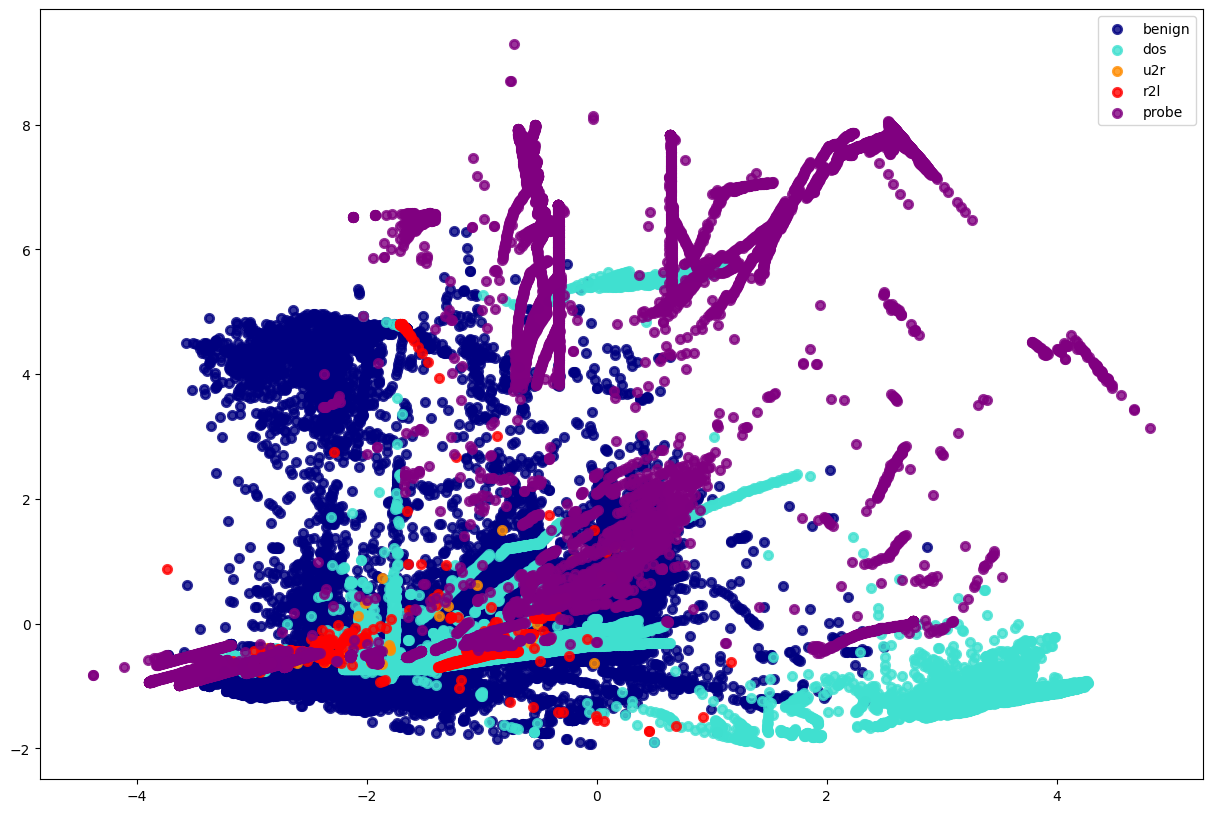

In [ ]:
# First, let's visualize the dataset (only numeric cols)

from sklearn.decomposition import PCA

# Use PCA to reduce dimensionality so we can visualize the dataset on a 2d plot
pca = PCA(n_components=2)
train_x_pca_cont = pca.fit_transform(train_x[numeric_cols])

plt.figure(figsize=(15,10))
colors = ['navy', 'turquoise', 'darkorange', 'red', 'purple']

for color, cat in zip(colors, category.keys()):
    plt.scatter(train_x_pca_cont[train_Y==cat, 0], train_x_pca_cont[train_Y==cat, 1],
                color=color, alpha=.8, lw=2, label=cat)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()

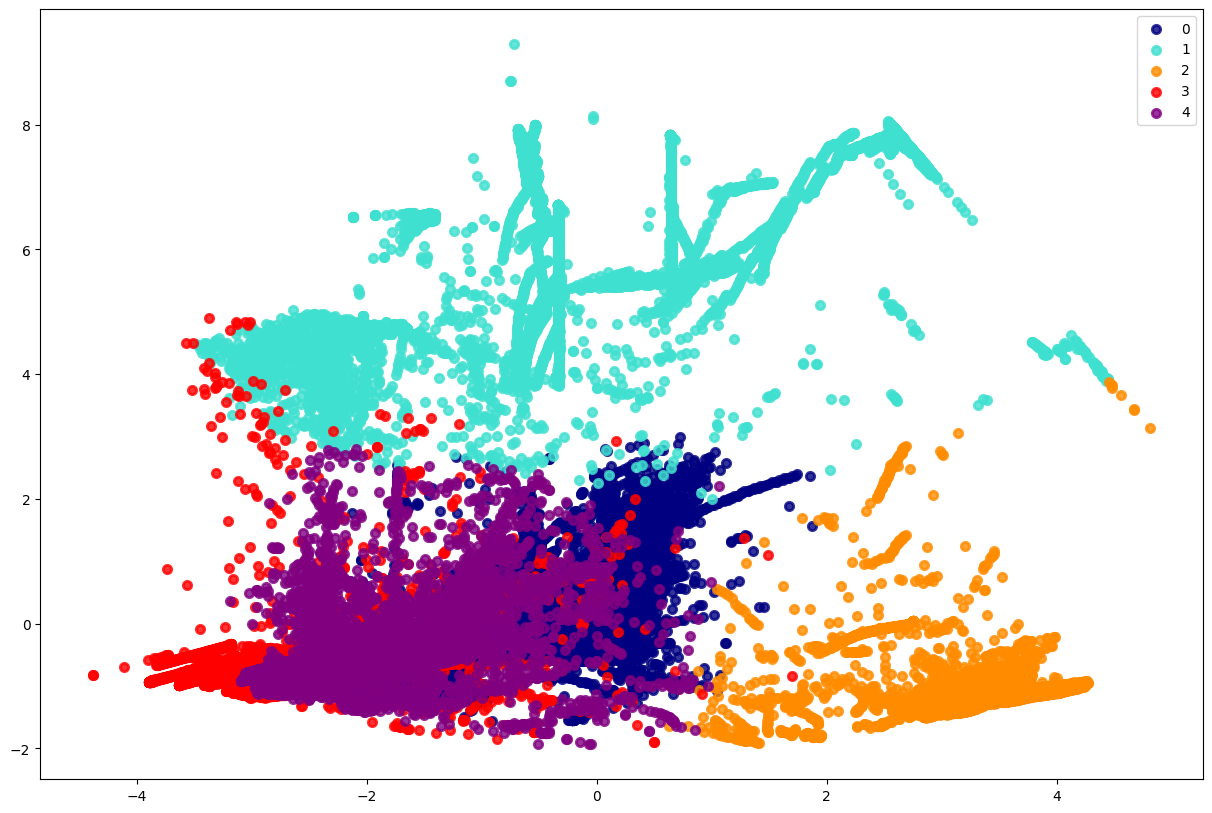

In [ ]:
# Apply k-means (k=5, only using numeric cols) + PCA + plot

from sklearn.cluster import KMeans

# Fit the training data to a k-means clustering estimator model
kmeans = KMeans(n_clusters=5, random_state=17).fit(train_x[numeric_cols])

# Retrieve the labels assigned to each training sample
kmeans_y = kmeans.labels_

# Plot in 2d with train_x_pca_cont
plt.figure(figsize=(15,10))
colors = ['navy', 'turquoise', 'darkorange', 'red', 'purple']

for color, cat in zip(colors, range(5)):
    plt.scatter(train_x_pca_cont[kmeans_y==cat, 0],
                train_x_pca_cont[kmeans_y==cat, 1],
                color=color, alpha=.8, lw=2, label=cat)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()

In [ ]:
print('Total number of features: {}'.format(len(train_x.columns)))
print('Total number of continuous features: {}'.format(len(train_x[numeric_cols].columns)))

Total number of features: 118
Total number of continuous features: 31


In [ ]:
from sklearn.metrics import completeness_score,\
    homogeneity_score, v_measure_score

print('Completeness: {}'.format(completeness_score(test_Y, pred_y)))
print('Homogeneity: {}'.format(homogeneity_score(test_Y, pred_y)))
print('V-measure: {}'.format(v_measure_score(test_Y, pred_y)))

Completeness: 0.5085280517664689
Homogeneity: 0.4007699422752623
V-measure: 0.44826395590276874


## Using "Attribute Ratio" (AR) feature selection

In [ ]:
averages = train_df.loc[:, numeric_cols].mean()

In [ ]:
averages_per_class = train_df[numeric_cols+['attack_category']].groupby('attack_category').mean()

In [ ]:
AR = {}
for col in numeric_cols:
    AR[col] = max(averages_per_class[col])/averages[col]

In [ ]:
AR

{'duration': np.float64(7.225829157212557),
 'src_bytes': np.float64(8.464064204948945),
 'dst_bytes': np.float64(9.154854355343401),
 'wrong_fragment': np.float64(2.742896335488928),
 'urgent': np.float64(173.03983516483518),
 'hot': np.float64(40.77451681709518),
 'num_failed_logins': np.float64(46.03855641845592),
 'num_compromised': np.float64(4.338539274983927),
 'num_root': np.float64(2.6091432537726016),
 'num_file_creations': np.float64(62.23362492770388),
 'num_shells': np.float64(326.11353550295854),
 'num_access_files': np.float64(4.694879248658319),
 'count': np.float64(2.1174082949142403),
 'srv_count': np.float64(1.1773191099992069),
 'serror_rate': np.float64(2.6310546426370274),
 'srv_serror_rate': np.float64(2.6432463184901596),
 'rerror_rate': np.float64(3.645586087828456),
 'srv_rerror_rate': np.float64(3.6677418023254273),
 'same_srv_rate': np.float64(1.5079612006047387),
 'diff_srv_rate': np.float64(4.069085485070197),
 'srv_diff_host_rate': np.float64(3.0815657101

In [ ]:
def binary_AR(df, col):
    series_zero = train_df[train_df[col] == 0].groupby('attack_category').size()
    series_one = train_df[train_df[col] == 1].groupby('attack_category').size()
    return max(series_one/series_zero)

In [ ]:
# Recreating dataframes with 2-class and 5-class labels

labels2 = ['normal', 'attack']
labels5 = ['normal', 'dos', 'probe', 'r2l', 'u2r']

train_df = pd.read_csv(train_file, names=header_names)
train_df['attack_category'] = train_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
train_df.drop(['success_pred'], axis=1, inplace=True)
    
test_df = pd.read_csv(test_file, names=header_names)
test_df['attack_category'] = test_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
test_df.drop(['success_pred'], axis=1, inplace=True)

train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()
test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

In [ ]:
train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)
train_df.drop('num_outbound_cmds', axis = 1, inplace=True)
test_df.drop('num_outbound_cmds', axis = 1, inplace=True)

In [ ]:
train_df['labels2'] = train_df.apply(lambda x: 'normal' if 'normal' in x['attack_type'] else 'attack', axis=1)
test_df['labels2'] = test_df.apply(lambda x: 'normal' if 'normal' in x['attack_type'] else 'attack', axis=1)

combined_df = pd.concat([train_df, test_df])
original_cols = combined_df.columns

combined_df = pd.get_dummies(combined_df, columns=nominal_cols, drop_first=True)

added_cols = set(combined_df.columns) - set(original_cols)
added_cols= list(added_cols)

In [ ]:
combined_df.attack_category = pd.Categorical(combined_df.attack_category)
combined_df.labels2 = pd.Categorical(combined_df.labels2)

combined_df['labels5'] = combined_df['attack_category'].cat.codes
combined_df['labels2'] = combined_df['labels2'].cat.codes

In [ ]:
train_df = combined_df[:len(train_df)]
test_df = combined_df[len(train_df):]

In [ ]:
for col in binary_cols+dummy_variables:
    cur_AR = binary_AR(train_df, col)
    if cur_AR:
        AR[col] = cur_AR

In [ ]:
train_df[train_df.service_Z39_50 == 1].groupby('attack_category').size()

attack_category
benign      0
dos       851
probe      11
r2l         0
u2r         0
dtype: int64

In [ ]:
len(binary_cols+added_cols)

87

In [ ]:
import operator
AR = dict((k, v) for k,v in AR.items() if not np.isnan(v))
sorted_AR = sorted(AR.items(), key=lambda x:x[1], reverse=True)

In [ ]:
sorted_AR

[('protocol_type_tcp', inf),
 ('num_shells', np.float64(326.11353550295854)),
 ('urgent', np.float64(173.03983516483518)),
 ('num_file_creations', np.float64(62.23362492770388)),
 ('flag_SF', 51.0),
 ('num_failed_logins', np.float64(46.03855641845592)),
 ('hot', np.float64(40.77451681709518)),
 ('logged_in', 10.569767441860465),
 ('dst_bytes', np.float64(9.154854355343401)),
 ('src_bytes', np.float64(8.464064204948945)),
 ('duration', np.float64(7.225829157212557)),
 ('dst_host_srv_diff_host_rate', np.float64(5.756880682756422)),
 ('dst_host_diff_srv_rate', np.float64(4.8373418489739075)),
 ('num_access_files', np.float64(4.694879248658319)),
 ('dst_host_same_src_port_rate', np.float64(4.393080378884036)),
 ('num_compromised', np.float64(4.338539274983927)),
 ('diff_srv_rate', np.float64(4.069085485070197)),
 ('dst_host_srv_rerror_rate', np.float64(3.66792052796591)),
 ('srv_rerror_rate', np.float64(3.6677418023254273)),
 ('rerror_rate', np.float64(3.645586087828456)),
 ('dst_host_rerr

In [ ]:
# Only keep features with AR value >= 0.01

features_to_use = []
for x,y in sorted_AR:
    if y >= 0.01:
        features_to_use.append(x)
        
features_to_use

['protocol_type_tcp',
 'num_shells',
 'urgent',
 'num_file_creations',
 'flag_SF',
 'num_failed_logins',
 'hot',
 'logged_in',
 'dst_bytes',
 'src_bytes',
 'duration',
 'dst_host_srv_diff_host_rate',
 'dst_host_diff_srv_rate',
 'num_access_files',
 'dst_host_same_src_port_rate',
 'num_compromised',
 'diff_srv_rate',
 'dst_host_srv_rerror_rate',
 'srv_rerror_rate',
 'rerror_rate',
 'dst_host_rerror_rate',
 'srv_diff_host_rate',
 'flag_S0',
 'wrong_fragment',
 'dst_host_srv_serror_rate',
 'srv_serror_rate',
 'serror_rate',
 'dst_host_serror_rate',
 'num_root',
 'count',
 'service_telnet',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'service_ftp_data',
 'same_srv_rate',
 'dst_host_count',
 'service_http',
 'srv_count',
 'root_shell',
 'service_private',
 'service_eco_i',
 'is_guest_login',
 'service_ftp',
 'flag_REJ',
 'flag_RSTR',
 'protocol_type_udp',
 'service_other',
 'service_domain_u',
 'service_smtp',
 'service_ecr_i',
 'flag_RSTO',
 'service_finger',
 'flag_SH',
 'service_Z

In [ ]:
len(features_to_use)

76

In [ ]:
len(sorted_AR) - len(features_to_use)

42

In [ ]:
train_df_trimmed = train_df[features_to_use]
test_df_trimmed = test_df[features_to_use]

In [ ]:
numeric_cols_to_use = list(set(numeric_cols).intersection(features_to_use))

In [ ]:
# Rescaling is necessary after reducing dimensions

standard_scaler = StandardScaler()

train_df_trimmed[numeric_cols_to_use] = standard_scaler.fit_transform(train_df_trimmed[numeric_cols_to_use])
test_df_trimmed[numeric_cols_to_use] = standard_scaler.transform(test_df_trimmed[numeric_cols_to_use])

## Applying advanced ensembling

In [ ]:
kmeans = KMeans(n_clusters=8, random_state=17)
kmeans.fit(train_df_trimmed[numeric_cols_to_use])
kmeans_train_y = kmeans.labels_

In [ ]:
pd.crosstab(kmeans_train_y, train_Y_bin)

attack_category,0,1
row_0,,
0,63119,7059
1,128,786
2,127,34702
3,2789,11456
4,30,0
5,0,4
6,631,4334
7,519,289


In [ ]:
train_df['kmeans_y'] = kmeans_train_y
train_df_trimmed['kmeans_y'] = kmeans_train_y

In [ ]:
kmeans_test_y = kmeans.predict(test_df_trimmed[numeric_cols_to_use])
test_df['kmeans_y'] = kmeans_test_y

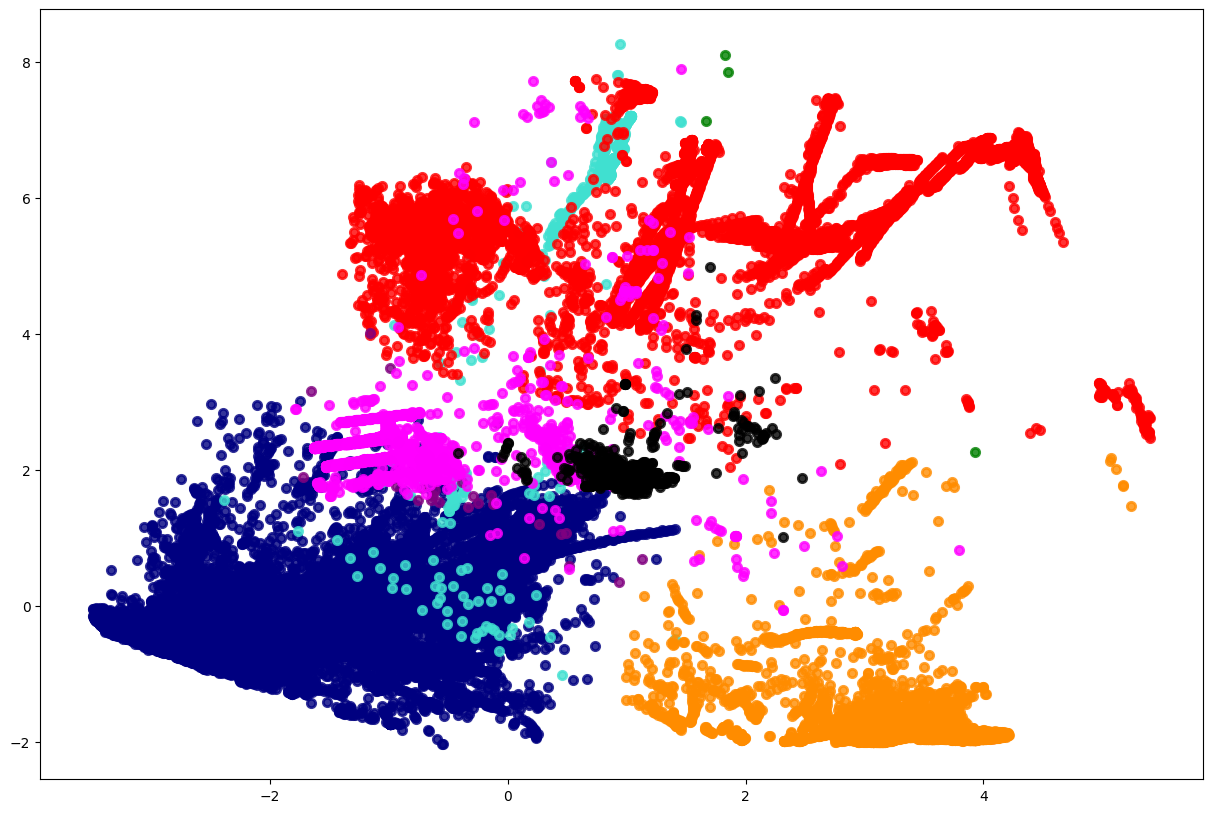

In [ ]:
pca8 = PCA(n_components=2)
train_df_trimmed_pca8 = pca8.fit_transform(train_df_trimmed)

plt.figure(figsize=(15,10))

colors8 = ['navy', 'turquoise', 'darkorange', 'red', 'purple', 'green', 'magenta', 'black']
labels8 = [0,1,2,3,4,5,6,7]

for color, cat in zip(colors8, labels8):
    plt.scatter(train_df_trimmed_pca8[train_df.kmeans_y==cat, 0], train_df_trimmed_pca8[train_df.kmeans_y==cat, 1],
                color=color, alpha=.8, lw=2, label=cat)

In [ ]:
pd.crosstab(test_df.kmeans_y, test_df.labels2)

labels2,0,1
kmeans_y,,
0,5265,9550
1,1,7
2,1998,7
3,5141,85
4,0,2
6,428,51
7,0,9


In [ ]:
# Ensembling strategy

# 1.	For clusters that have an aggregate size of fewer than 200 samples, we consider them outliers and assign them the attack label.

# 2.	For clusters with more than 95% of samples belonging to a single class, (either attack or benign) we assign the dominant label to the entire cluster.

# 3.	For each of the remaining clusters, we train a separate random forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

### Cluster 0 - Random Forest Classifier (Strategy Option 3)

In [ ]:
train_y0 = train_df[train_df.kmeans_y==0]
test_y0 = test_df[test_df.kmeans_y==0]
rfc = RandomForestClassifier(n_estimators=500, max_depth=20, random_state=17).fit(train_y0.drop(['labels2', 'labels5', 'kmeans_y', 'attack_category', 'attack_type'], axis=1), train_y0['labels2'])
pred_y0 = rfc.predict(test_y0.drop(['labels2', 'labels5', 'kmeans_y', 'attack_category', 'attack_type'], axis=1))
print("cluster {} score is {}, {}".format(0, accuracy_score(pred_y0, test_y0['labels2']), accuracy_score(pred_y0, test_y0['labels2'], normalize=False)))

print(confusion_matrix(test_y0['labels2'], pred_y0))

cluster 0 score is 0.7343233209584881, 10879.0
[[1519 3746]
 [ 190 9360]]


### Cluster 1 - Dominant Label Zero (Strategy Option 2)

In [ ]:
print(confusion_matrix(test_df[test_df.kmeans_y==1]['labels2'], np.zeros(len(test_df[test_df.kmeans_y==1]))))

[[1 0]
 [7 0]]


### Cluster 2 - Dominant Label Zero (Strategy Option 2)

In [ ]:
print(confusion_matrix(test_df[test_df.kmeans_y==2]['labels2'], np.zeros(len(test_df[test_df.kmeans_y==2]))))

[[1998    0]
 [   7    0]]


### Cluster 3 - Empty Cluster

### Cluster 4 - Random Forest Classifier (Strategy Option 3)

In [ ]:
train_y0 = train_df[train_df.kmeans_y==4]
test_y0 = test_df[test_df.kmeans_y==4]
rfc = RandomForestClassifier(n_estimators=500, max_depth=20, random_state=17).fit(train_y0.drop(['labels2', 'labels5', 'kmeans_y', 'attack_category', 'attack_type'], axis=1), train_y0['labels2'])
pred_y0 = rfc.predict(test_y0.drop(['labels2', 'labels5', 'kmeans_y', 'attack_category', 'attack_type'], axis=1))
print("cluster {} score is {}, {}".format(4, accuracy_score(pred_y0, test_y0['labels2']), accuracy_score(pred_y0, test_y0['labels2'], normalize=False)))

print(confusion_matrix(test_y0['labels2'], pred_y0))

cluster 4 score is 1.0, 2.0
[[2]]


### Cluster 5 - Outlier/Attack (Strategy Option 1)

In [ ]:
print(confusion_matrix(test_df[test_df.kmeans_y==5]['labels2'], np.ones(len(test_df[test_df.kmeans_y==5]))))

[]


### Cluster 6 - Outlier/Attack (Strategy Option 1)

In [ ]:
print(confusion_matrix(test_df[test_df.kmeans_y==6]['labels2'], np.ones(len(test_df[test_df.kmeans_y==6]))))

[[  0 428]
 [  0  51]]


### Cluster 7 - Dominant Label Zero (Strategy Option 2)

In [ ]:
print(confusion_matrix(test_df[test_df.kmeans_y==7]['labels2'], np.zeros(len(test_df[test_df.kmeans_y==7]))))

[[0 0]
 [9 0]]


### Combined Results: k-means + Random Forest Classifier ensembling with AR feature selection

In [ ]:
# combined results:
num_samples = 22544
false_pos = 3177 + 22 + 1 + 8
false_neg = 152 + 87 + 6 + 11 + 5

print('True positive %: {}'.format(1-(false_pos/num_samples)))
print('True negative %: {}'.format(1-(false_neg/num_samples)))

True positive %: 0.8577004968062456
True negative %: 0.9884226401703335
